## MSA vs PSP

## Imports and Function Definitions

In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    
    get_metrics(clf.best_estimator_, Xh, yh)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [12]:
param_grid = {
    "classifier__C": np.logspace(-5, 10, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.2
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score)
}
_scoring='f1_micro'
_data = pd.read_excel('training_data_1004.xlsx')
_random_seed = 55

## 5. PSP (positive) vs MSA (negative)

In [13]:
# Get the data
data4 = group_classes(_data, {2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.2s finished


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.65      0.85      0.73        13
          1       0.92      0.80      0.86        30

avg / total       0.84      0.81      0.82        43


recall	0.8
precision	0.923076923077
auc	0.823076923077
specificity	0.846153846154
npv	0.647058823529
accuracy	0.813953488372


In [14]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00979995727539	0.00128882978156
score_time	0.00571489334106	0.000762107917512
test_recall	0.827894736842	0.0880002518254
train_recall	0.883829113924	0.0148216173102
test_precision	0.928095238095	0.0704761904762
train_precision	0.983406175255	0.0102120273208
test_auc	0.863947368421	0.0518552301454
train_auc	0.931200271248	0.0050195471367
test_specificity	0.9	0.0968904283304
train_specificity	0.978571428571	0.0133630620956
test_npv	0.797167277167	0.0819255024658
train_npv	0.856620242754	0.0142625303036
test_accuracy	0.857575757576	0.0522327265867
train_accuracy	0.923082788671	0.00584028368111


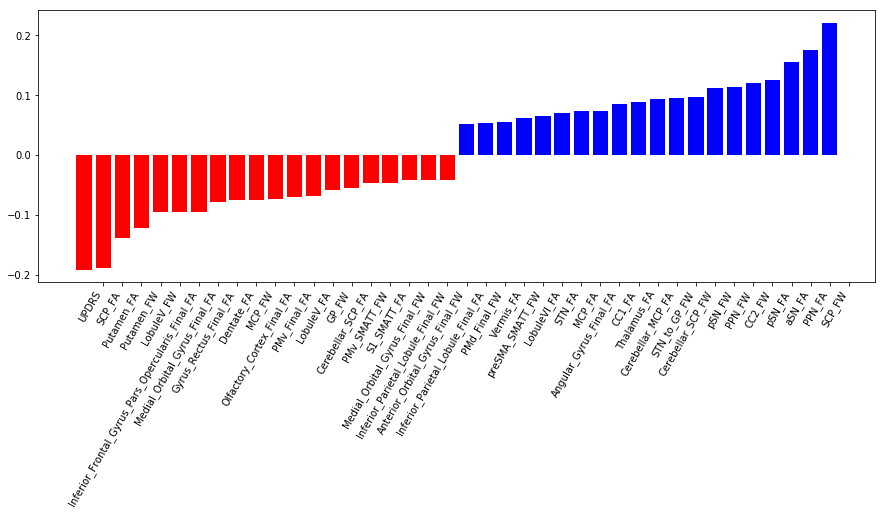

Age	0.0265793228734
Sex	0.0137385981805
UPDRS	-0.191348982155
aSN_FA	0.155500703997
Caudate_FA	-0.032073065438
CC2_FA	0.048557237301
GP_FA	-0.0265275819068
LobuleVI_FA	0.0655903147304
LobuleV_FA	-0.0682397092684
MCP_FA	0.0734804866325
pSN_FA	0.126022542619
Putamen_FA	-0.137789792447
SCP_FA	-0.18760593935
STN_FA	0.0701331402164
Thalamus_FA	0.0889298300908
Vermis_FA	0.0553037382956
RN_FA	-0.000218747284771
PPN_FA	0.17539843487
Dentate_FA	-0.075581326714
CC1_FA	0.0859970781728
aSN_FW	-0.0276181245913
Caudate_FW	0.0286060215371
CC2_FW	0.119857120016
GP_FW	-0.0579391178836
LobuleVI_FW	-0.0201289411282
LobuleV_FW	-0.0953589398344
MCP_FW	-0.0748371546624
pSN_FW	0.111225626419
Putamen_FW	-0.122312723609
SCP_FW	0.220893067313
STN_FW	-0.0075684695256
Thalamus_FW	0.0215412006594
Vermis_FW	0.0376982393626
RN_FW	0.0359190386146
PPN_FW	0.113136688427
Dentate_FW	-0.0353641506556
CC1_FW	0.00383993596967
Angular_Gyrus_Final_FA	0.0737110688046
Anterior_Orbital_Gyrus_Final_FA	-0.025233584478
Calcarine_Su

In [15]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.65      0.85      0.73        13
          1       0.92      0.80      0.86        30

avg / total       0.84      0.81      0.82        43



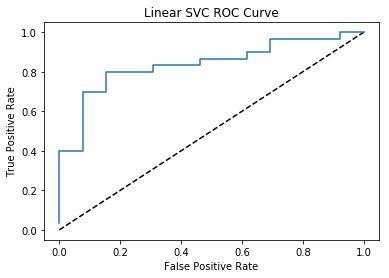

0.0 0.0333333333333
0.0 0.4
0.0769230769231 0.4
0.0769230769231 0.7
0.153846153846 0.7
0.153846153846 0.8
0.307692307692 0.8
0.307692307692 0.833333333333
0.461538461538 0.833333333333
0.461538461538 0.866666666667
0.615384615385 0.866666666667
0.615384615385 0.9
0.692307692308 0.9
0.692307692308 0.966666666667
0.923076923077 0.966666666667
0.923076923077 1.0
1.0 1.0


In [16]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 6. MSA (positive) vs PSP (negative)

In [17]:
# Get the data
data4 = group_classes(_data, {2:1, 3:0})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:    7.0s remaining:    1.2s


Best parameters set found on development set:

{'classifier__C': 0.01438449888287663}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.92      0.80      0.86        30
          1       0.65      0.85      0.73        13

avg / total       0.84      0.81      0.82        43


recall	0.846153846154
precision	0.647058823529
auc	0.823076923077
specificity	0.8
npv	0.923076923077
accuracy	0.813953488372


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.2s finished


In [18]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00980505943298	0.000739129674892
score_time	0.00504493713379	0.000708894624474
test_recall	0.9	0.0968904283304
train_recall	0.978571428571	0.0133630620956
test_precision	0.797167277167	0.0819255024658
train_precision	0.856620242754	0.0142625303036
test_auc	0.863947368421	0.0518552301454
train_auc	0.931200271248	0.0050195471367
test_specificity	0.827894736842	0.0880002518254
train_specificity	0.883829113924	0.0148216173102
test_npv	0.928095238095	0.0704761904762
train_npv	0.983406175255	0.0102120273208
test_accuracy	0.857575757576	0.0522327265867
train_accuracy	0.923082788671	0.00584028368111


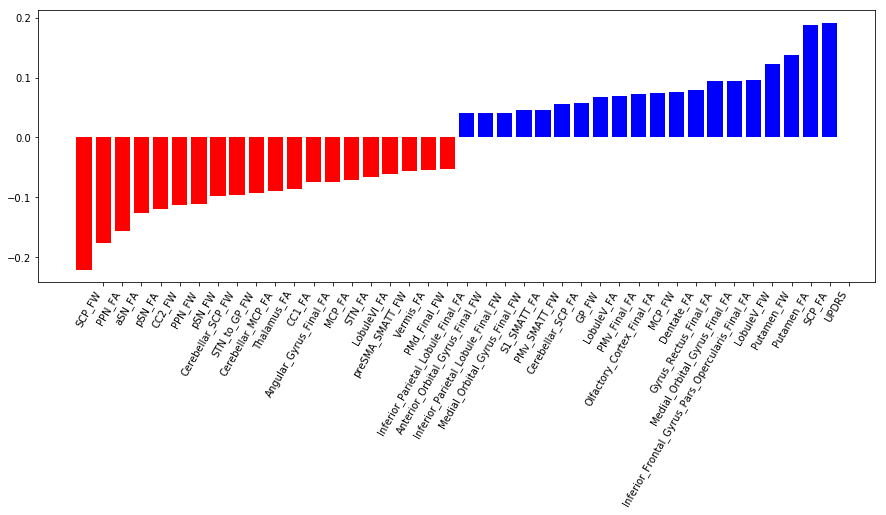

Age	-0.0264481629344
Sex	-0.0138436195484
UPDRS	0.191448008395
aSN_FA	-0.155404150497
Caudate_FA	0.0320097057486
CC2_FA	-0.0485113586753
GP_FA	0.0264460478938
LobuleVI_FA	-0.0656805051998
LobuleV_FA	0.0681883173609
MCP_FA	-0.0734630806885
pSN_FA	-0.125901128447
Putamen_FA	0.137837626426
SCP_FA	0.187643193724
STN_FA	-0.0702483468961
Thalamus_FA	-0.0887794748811
Vermis_FA	-0.0551349496139
RN_FA	0.000153168537747
PPN_FA	-0.175324400193
Dentate_FA	0.0755748801216
CC1_FA	-0.0860375767967
aSN_FW	0.0275898341882
Caudate_FW	-0.0285703026263
CC2_FW	-0.119799743574
GP_FW	0.0581390366364
LobuleVI_FW	0.0201319885749
LobuleV_FW	0.0954960808324
MCP_FW	0.0748060951524
pSN_FW	-0.111261619569
Putamen_FW	0.122285616031
SCP_FW	-0.220842796867
STN_FW	0.0074427378839
Thalamus_FW	-0.0215325626801
Vermis_FW	-0.0376911980468
RN_FW	-0.0358566904662
PPN_FW	-0.113249246783
Dentate_FW	0.0353614857219
CC1_FW	-0.00391344062175
Angular_Gyrus_Final_FA	-0.0736304382492
Anterior_Orbital_Gyrus_Final_FA	0.0251982973072
C

In [19]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

             precision    recall  f1-score   support

          0       0.92      0.80      0.86        30
          1       0.65      0.85      0.73        13

avg / total       0.84      0.81      0.82        43



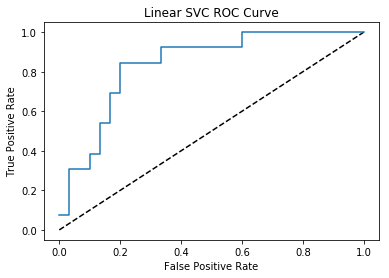

0.0 0.0769230769231
0.0333333333333 0.0769230769231
0.0333333333333 0.307692307692
0.1 0.307692307692
0.1 0.384615384615
0.133333333333 0.384615384615
0.133333333333 0.538461538462
0.166666666667 0.538461538462
0.166666666667 0.692307692308
0.2 0.692307692308
0.2 0.846153846154
0.333333333333 0.846153846154
0.333333333333 0.923076923077
0.6 0.923076923077
0.6 1.0
1.0 1.0


In [20]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)